In [2]:
import pandas as pd
import os
import glob
import librosa
from tqdm import tqdm

In [3]:
train_data = pd.read_csv("train_metadata.csv")

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24459 entries, 0 to 24458
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     24459 non-null  object 
 1   secondary_labels  24459 non-null  object 
 2   type              24459 non-null  object 
 3   latitude          24081 non-null  float64
 4   longitude         24081 non-null  float64
 5   scientific_name   24459 non-null  object 
 6   common_name       24459 non-null  object 
 7   author            24459 non-null  object 
 8   license           24459 non-null  object 
 9   rating            24459 non-null  float64
 10  url               24459 non-null  object 
 11  filename          24459 non-null  object 
dtypes: float64(3), object(9)
memory usage: 2.2+ MB


## Missing data
1. From the above simple info printing, we come to know that there are a total of 24459 samples but the latitude and longitude values aren't available for all samples
2. There 378 rows without latitude and longitude informations
3. Methods to solve this:
    * Interpolate the corresponding data with mean or median values - Median Interpolating will be a better choice to avoid the problem of Outliers(outliers will influence the mean of the data).
    * Train a smaller ML Model and make it predict for the subset of the data where those info is not present.   
    

In [5]:
train_data['latitude'].describe()

count    24081.000000
mean        32.537040
std         19.440382
min        -43.524000
25%         17.160100
50%         37.155100
75%         49.114400
max         71.964000
Name: latitude, dtype: float64

In [6]:
train_data['latitude'].median()

37.1551

In [7]:
train_data[train_data['latitude'].isna()]

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
35,asbfly,[],['song'],NaN,NaN,Muscicapa dauurica,Asian Brown Flycatcher,D.Farrow,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/49755,asbfly/XC49755.ogg
93,asbfly,[],[''],NaN,NaN,Muscicapa dauurica,Asian Brown Flycatcher,王自堃,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/825177,asbfly/XC825177.ogg
137,ashdro1,[],['song'],NaN,NaN,Dicrurus leucophaeus,Ashy Drongo,KALYAN SINGH SAJWAN,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/312261,ashdro1/XC312261.ogg
144,ashdro1,[],['song'],NaN,NaN,Dicrurus leucophaeus,Ashy Drongo,brendan sloan,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/335978,ashdro1/XC335978.ogg
152,ashdro1,[],['song'],NaN,NaN,Dicrurus leucophaeus,Ashy Drongo,David Farrow,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/37740,ashdro1/XC37740.ogg
...,...,...,...,...,...,...,...,...,...,...,...,...
23992,zitcis1,[],"['male', 'song']",NaN,NaN,Cisticola juncidis,Zitting Cisticola,José Carlos Sires,Creative Commons Attribution-NonCommercial-Sha...,2.0,https://www.xeno-canto.org/179035,zitcis1/XC179035.ogg
24416,zitcis1,[],[''],NaN,NaN,Cisticola juncidis,Zitting Cisticola,Carlos Pereira,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://xeno-canto.org/788579,zitcis1/XC788579.ogg
24444,zitcis1,[],[''],NaN,NaN,Cisticola juncidis,Zitting Cisticola,Steven Van Garsse,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://xeno-canto.org/826917,zitcis1/XC826917.ogg
24445,zitcis1,[],[''],NaN,NaN,Cisticola juncidis,Zitting Cisticola,Maarten Sluijter,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/827436,zitcis1/XC827436.ogg


## Labels

In [15]:
print(f"The number of unique labels present in the dataset are :{train_data.primary_label.nunique()}")

#lets create a list of alphabetically arranged class name so that we can create label index using the list index
#it's better to save the sorted label list in a .txt file
unique_classes = sorted(train_data.primary_label.unique().tolist())
#now lets write this list into a .txt file
f = open("labels.txt", "w")
for cls in unique_classes:
    f.write(f"{cls}\n")
f.close()

The number of unique labels present in the dataset are :182


In [17]:
#lets load the label list from the .txt file
labels = [x.strip() for x in open("labels.txt", "r").readlines()]

#now lets create a new column in the metadata named class_index which is just a numerical representation of the primary_label column
train_data["class_index"] = train_data.primary_label.apply(lambda x: labels.index(x))

/home/tensorthiru/anaconda3/envs/clef/lib/python3.8/site-packages/seaborn/distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


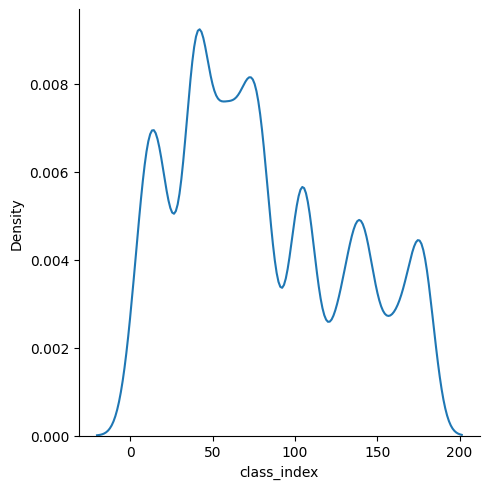

In [23]:
#lets see how many unique labels are there in our dataset
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(data=train_data, x='class_index', ax=ax, kind='kde')
plt.show()

## Audio Feature Extraction - MelSpectrogram

In [132]:
from librosa.feature import melspectrogram
import librosa
import numpy as np
from pydub import AudioSegment as AS
import IPython
import IPython.display as ipd

In [116]:
from dataclasses import dataclass
@dataclass
class cfg():
    MAXLEN: int = 1000000
    CHUNK_SIZE: int = 1000000
    NMELS: int = 256
    sample_audio_path: str = f"train_audio/{train_data.loc[0, 'filename']}"

In [117]:
print(cfg())

cfg(MAXLEN=1000000, CHUNK_SIZE=1000000, NMELS=256, sample_audio_path='train_audio/asbfly/XC134896.ogg')


In [157]:
#Helper Functions

def normalize(x):
    return np.float32(x)/2**15

def read(file, norm=False):
    try: a = AS.from_ogg(file)
    except: return np.zeros(MAXLEN)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2: y = y.reshape((-1, 2))
    if norm: return a.frame_rate, normalize(y)
    if not norm: return a.frame_rate, np.float32(y)

def to_imagenet(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = (V - norm_min) / (norm_max - norm_min)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return np.stack([V]*3, axis=-1)

def create_melspec(y, sr, to='img'):
    y = 
    melspec = melspectrogram(y=y, n_mels=cfg.NMELS)
    if to == 'img':
        return librosa.power_to_db(melspec)
    elif to == 'train':
        return to_imagenet(melspec)

def viz_sample():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30,5))
    
    species = cfg.sample_audio_path.split("/")[-2]
    ax[0].set_title(species + " signal", fontsize=16)
    ax[1].set_title(species + " melspectrogram", fontsize=16)

    sr, data = read(cfg.sample_audio_path)
    signals, melsp_features = data, create_melspec(data,sr)

    ax[0].plot(signals, 'crimson')
    ax[1].imshow(melsp_features)
    display(ipd.Audio(cfg.sample_audio_path))
    plt.show()

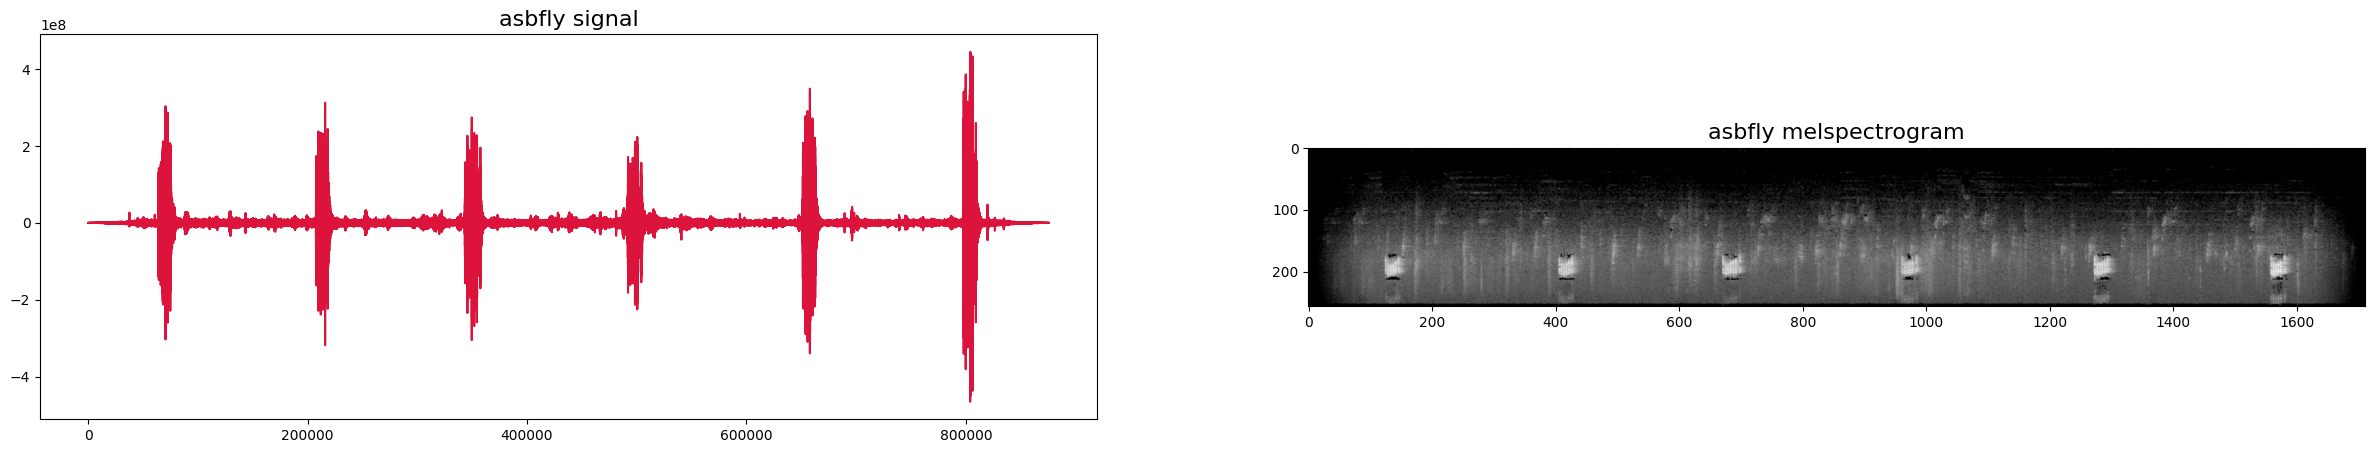

In [141]:
viz_sample()

In [142]:
l = f"home/tensorthiru/CLEF/birdclef-2024/train_audio/{cfg.sample_audio_path}"

In [145]:
"/".join(l.split("/")[-2:])

'asbfly/XC134896.ogg'

In [162]:
from PIL import Image
sr, y = read(cfg.sample_audio_path)
msp = Image.fromarray(create_melspec(y, sr).astype(np.uint8))

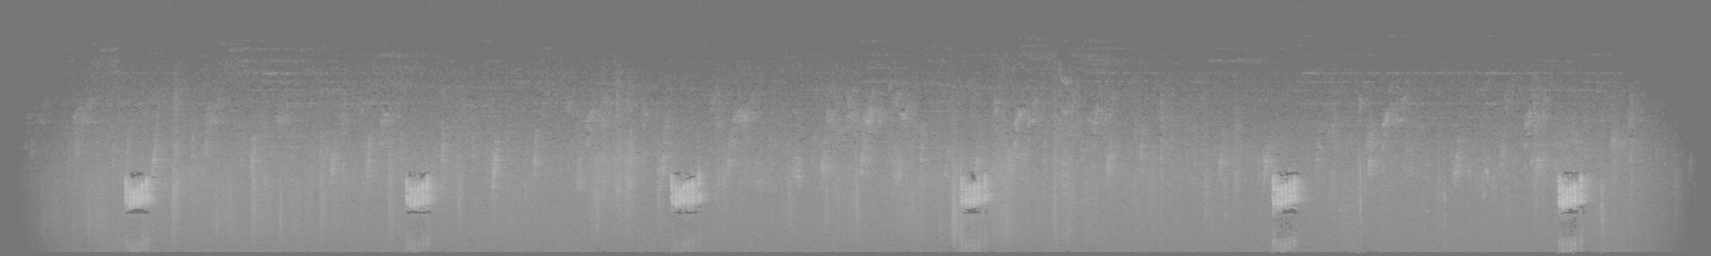

In [164]:
msp

In [1]:
from torchmetrics.classification import MulticlassROC

In [2]:
mc = MulticlassROC(num_classes=182)

In [5]:
mc.update()

TypeError: update() missing 2 required positional arguments: 'preds' and 'target'